# CAPSTONE PROJECT 2: A COMPUTER VISION MODEL WHICH DETECTS BONE FRACTURES IN THE UPPER EXTREMITIES NAMELY: WRISTS, FOREARMS, UPPER ARM, & SHOULDER FRACTURES
#### Data Pre-Processing



***
Goal: Create a cleaned development dataset you can use to complete the modeling step of your project. <br>
This is going to be unlike regular preprocessing:
- first of all, I have already a separated training, testing and validation data sets.
- secondly, since we are using PyTorch for the image evaluation and training, the data is in the image Tensors. In the EDA phase of the project we developed tools for accessing converting and even visualizing to a degree the patterns that can be found in the images.
- Therefore there will be a good deal of code which will copy and pasted from the last project inorder to get us started, but a lot of this will be focused on image prep before feeding to the model to improve it's functionality.
***

In [1]:
# Import modules:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from random import sample

# Image Analysis imports
import sklearn as skl
import skimage as ski
import cv2
from skimage.filters import sobel
from skimage import exposure
from skimage.filters import try_all_threshold
from skimage.filters import threshold_yen
from skimage import measure
from skimage.segmentation import slic

# PyTorch Analysis imports
import torch
from torch import nn
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import albumentations as A
import torchvision
from torchvision.utils import draw_bounding_boxes, draw_segmentation_masks
import torchvision.transforms.functional as F

# Feature extraction imports
from torchvision.models import resnet50
from torchvision.models.feature_extraction import get_graph_node_names
from torchvision.models.feature_extraction import create_feature_extractor
from torchvision.models.detection.mask_rcnn import MaskRCNN
from torchvision.models.detection.backbone_utils import LastLevelMaxPool
from torchvision.ops.feature_pyramid_network import FeaturePyramidNetwork
from torch.utils.data import Dataset
from PIL import Image

Derived from my Explorations during EDA, I believe that simply enhancing images will be sufficient to improve model performance when "seeing" into the image to detect fractures.
after that I think any other transformations of the image data will be superfluous.  Therefore I will proceed to copy in my custom functions which were created during EDA and proceed to make adjustments as necessary for data prep for the model.

In [5]:
#Import the data as Pandas DataFrames: df_test, df_train, df_val
data_links = [r'C:\Users\micha\OneDrive\Documents\GitHub\SpringBoardDataScience\Capstone_Project_2\Data\df_test.csv', 
              r'C:\Users\micha\OneDrive\Documents\GitHub\SpringBoardDataScience\Capstone_Project_2\Data\df_train.csv', 
              r'C:\Users\micha\OneDrive\Documents\GitHub\SpringBoardDataScience\Capstone_Project_2\Data\df_val.csv']

def multi_df(list):
    temp_list = []
    for i in list:
        temp_list.append(pd.read_csv(i))
    return temp_list
    
df_test, df_train, df_val = multi_df(data_links)

# Trim the extra index column
df_train.drop(columns='Unnamed: 0', inplace=True)
df_test.drop(columns='Unnamed: 0', inplace=True)
df_val.drop(columns='Unnamed: 0', inplace=True)


In [6]:
# GLOBALS
# Project Main Directory path
dir_path = r"C:\Users\micha\OneDrive\Documents\GitHub\SpringBoardDataScience\Capstone_Project_2"

# Data Paths
train_dir_path = r"C:\Users\micha\OneDrive\Documents\GitHub\SpringBoardDataScience\Capstone_Project_2\Data\train"
val_dir_path = r"C:\Users\micha\OneDrive\Documents\GitHub\SpringBoardDataScience\Capstone_Project_2\Data\valid"
test_dir_path = r"C:\Users\micha\OneDrive\Documents\GitHub\SpringBoardDataScience\Capstone_Project_2\Data\test"

# Image Scalars
Width = 400
Height = 400

# Labels
num_classes = 8
classes=['elbow positive', 'fingers positive', 'forearm fracture', 'humerus fracture', 'humerus', 'shoulder fracture', 'wrist positive', 'no fracture']
c2l={k:v for k,v in list(zip(classes,list(range(num_classes))))}
l2c={v:k for k,v in c2l.items()}

In [7]:
# IMAGE FUNCTIONS FOR ANALYSIS
# A function for preparing images for analysis:
def img_import(img_path, height=Height, width=Width):
    image = cv2.imread(img_path)
    image = cv2.resize(image,(height,width))
    image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    return image, image_gray

       

# a function for displaying an image for EDA (Borrowed from DataCamp Course: Make Images Come Alive with SciKit-Image)
def img_render(img_path, tar_path, cmap_type='gray', height=Height, width=Width):
    # Read and scale image data
    image, image_gray = img_import(img_path, height, width)
    
    # Read target path
    file = open(tar_path, 'r')
    
    # Set up bbox
    bbox = bboxes(file)
    for box in bbox['bboxes']:
        xmin, ymin, xmax, ymax = box[0], box[1], box[2], box[3]
        sp, ep=(xmin, ymin), (xmax, ymax)
        image = cv2.rectangle(image, sp, ep, (0, 255, 0), 2)
    
    # Display Image
    plt.imshow(image, cmap=cmap_type)
    plt.title(l2c[bbox['label']])
    plt.axis('off')
    plt.show()
    
# function which converts the albumentated values back to 'pascal voc' representation
def to_pascal(width, height, x, y, w, h):

    xmax = int((x*width) + (w * width)/2.0)
    xmin = int((x*width) - (w * width)/2.0)
    ymax = int((y*height) + (h * height)/2.0)
    ymin = int((y*height) - (h * height)/2.0)

    return xmin, ymin, xmax, ymax

# access label and bbox data, convert to drawable values and store in bbox variable.
def bboxes(file, i=1):
    target=list(map(float,file.read().split()))
    print(target)
    bbox = []
    while i < len(target):
        x, y, w, h = target[i:i+4]
        bbox.append([x, y, w, h])
        i += 4
        
    for box in bbox:
        xmin, ymin, xmax, ymax = to_pascal(Width, Height, box[0], box[1], box[2], box[3])
        box[0:4] = [xmin, ymin, xmax, ymax]
    
    bbox = {'label': int(target[0]),
            'bboxes': bbox}
    print(bbox)
     
    return bbox

# A function that gets basic image data and assigns it to it's respective row in a DataFrame
def img_basics(df, path):
    df['image_shape'] = None
    df['image_size'] = None
    i = 0
    while i < len(df):
        img_file = rf"{path}\images\{df['images'].iloc[i]}"
        img = cv2.imread(img_file)
        df['image_shape'].iloc[i] = img.shape
        df['image_size'].iloc[i] = img.size
        i += 1
        
# A function for just displaying an image
def show_image(image, cmap_type, title='image'):
    plt.imshow(image, cmap=cmap_type)
    plt.title(title)
    plt.axis('off')
    plt.show()

# A function for selecting Random images from a DataFrame    
def random_image_select(df, path):
    length = len(df)
    index = np.random.randint(0, length)
    i_file = rf"{path}\images\{df['images'].iloc[index]}"
    file = rf"{path}\labels\{df['labels'].iloc[index]}"
    return i_file, file

# A Function for rendering features in selected images.
def feature_render(img_path, tar_path, height=Height, width=Width):
    # Import images as color and grayscale
    image, image_gray = img_import(img_path, height, width)
    
    # Feature extraction
    eq_image = exposure.equalize_adapthist(image_gray, clip_limit=0.03)
    thresh = threshold_yen(eq_image)
    binary = eq_image >= thresh
    contours = measure.find_contours(binary, 0.000001)
    segs = slic(eq_image, n_segments=1800)
    seg_image = ski.color.label2rgb(segs, eq_image, kind='avg')
    
    # Display Images
    fig1, axes = plt.subplots(nrows=1, ncols=5,
                         sharey=True,
                         figsize=(20, 20))
    axes[0].imshow(image, cmap=plt.cm.gray)
    axes[0].set_xticks([])
    axes[0].set_yticks([])
    axes[0].set_title('Original image')

    axes[1].imshow(eq_image, cmap=plt.cm.gray)
    axes[1].set_xticks([])
    axes[1].set_yticks([])
    axes[1].set_title('Enhanced Image')

    axes[2].imshow(binary, cmap=plt.cm.gray)
    axes[2].set_xticks([])
    axes[2].set_yticks([])
    axes[2].set_title('Yen Thresholding')

    axes[3].imshow(binary, cmap=plt.cm.gray)
    for contour in contours:
        axes[3].plot(contour[: , 1], contour[:, 0], linewidth=2)
    axes[3].axis('image')
    axes[3].set_xticks([])
    axes[3].set_yticks([])
    axes[3].set_title('Contours')

    axes[4].imshow(seg_image)
    axes[4].set_xticks([])
    axes[4].set_yticks([])
    axes[4].set_title('Segmented Image')

    plt.show()
    
####################################################################################
### PyTorch Analysis Functions: ####################################################
####################################################################################
  
def show_tensor_images(image_tensor, num_images=25, size=(1, 28, 28)):
    '''
    Function for visualizing images: Given a tensor of images, number of images, and
    size per image, plots and prints the images in an uniform grid.
    '''
    image_shifted = image_tensor
    image_unflat = image_shifted.detach().cpu().view(-1, *size)
    image_grid = make_grid(image_unflat[:num_images], nrow=5)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()

def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fix, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
        
def import_boxes(list):
    '''
    Function for converting the text data in the labels files into functional
    dictionaries:  Given a list from a read file it converts that list and 
    returns a dictionary with correlated label and coordinate data.
    '''
    # Convert strings to ints and floats
    for i in range(0, len(list)):
        if len(list[i]) == 1:
            list[i] = int(float(list[i]))
        else:
            list[i] = float(list[i])
    # initialize variables        
    boxes = {'labels': [],
              'coords': []}
    i = -1
    neg_len = len(list) - (len(list) * 2)
    temp_list = []
    # Convert list to a functional dictionary of labels and coords
    while i >=  neg_len:
        if type(list[i]) == int:
            boxes['labels'].append(list[i])
            boxes['coords'].append(temp_list)
            temp_list = []
        else:
            temp_list.insert(0, list[i])
        i -= 1
    
    return boxes

def display_features(img, return_nodes, out, tensor, tensor_index):
    
    fig, ax = plt.subplots(4, 5, figsize=(25,20))

    for i, layer in enumerate(return_nodes):
        feat_maps = out[layer].numpy().squeeze(0)
        feat_maps = sample(list(feat_maps), 4)
        labeled_image = draw_bounding_boxes(img, boxes=tensor.get_boxes(tensor_index), colors="red", labels=[str(x) for x in tensor.get_labels(tensor_index)])
        ax[i][0].imshow(labeled_image.permute(1, 2, 0))
        ax[i][0].set_xticks([])
        ax[i][0].set_yticks([])
        for j, feat_map in enumerate(feat_maps):
            sns.heatmap(feat_map, ax=ax[i][j+1], cbar=False)
            ax[i][j+1].set_xticks([])
            ax[i][j+1].set_yticks([])
            ax[i][j+1].set_title(f"{layer}: ({feat_map.shape[0]} X {feat_map.shape[1]})")
        
    plt.show()

#### That mostly sets the stage for this phase next is to create our tensors, and our preprocess pipelines to meet our standard criterion.

In [8]:
# Declare our image dataset class and intrinsic functions for  use.
class ImageDataset(Dataset):
    def __init__(self, root, transform=None, mode='train'):
        self.transform = transform
        self.files = [rf"{root}\Data\{mode}\images\{name}" for name in os.listdir(root + rf"\Data\{mode}\images") if name.endswith(".jpg")]
        self.labels = {}
        self.boxes = {}
        assert len(self.files) > 0, "Make sure you downloaded the images!"

    def get_image(self, index):
        item = self.transform(Image.open(self.files[index % len(self.files)]))
        if item.shape[0] != 3: 
            item = item.repeat(3, 1, 1)
        # Old versions of PyTorch didn't support normalization for different-channeled images
        return item
    
    def get_labels(self, index):
        if index in self.labels:
            return self.labels[index]
        labels = []
        boxes = []
        text_file = self.files[index % len(self.files)].replace(".jpg", ".txt").replace("images", "labels")
        with open(text_file, mode="r") as f:
            lines = f.readlines()
            for line in lines:
                values = [value for value in line.split()]
                bboxes = import_boxes(values)
                for i in range(0, len(bboxes['labels'])):
                    coords = bboxes['coords'][i]
                    coords = torch.reshape(torch.FloatTensor(coords), (int(len(coords)/2), 2))
                    size = torch.tensor([self.get_image(index).shape[2], self.get_image(index).shape[1]])
                    min_coords = torch.min(coords, dim=0).values * size
                    max_coords = torch.max(coords, dim=0).values * size
                    box = torch.cat((min_coords, max_coords), dim=0).tolist()
                    labels.append(l2c[bboxes['labels'][i]])
                    boxes.append(box)
        if not labels:
            labels.append('no fracture')
            self.labels[index] = labels
            self.boxes[index] = torch.FloatTensor([[0,0,0,0]])
        else:
            self.labels[index] = labels
            self.boxes[index] = torch.FloatTensor(boxes)
        return labels
    
    def get_boxes(self, index):
        if index in self.boxes:
            return self.boxes[index]
        _ = self.get_labels(index)
        return self.boxes[index]

    def __len__(self):
        return len(self.files)

In [9]:
# Set prepocess pipline
load_shape = 384

transform = transforms.Compose([
    transforms.Resize(load_shape),
    transforms.ToTensor(),
   # transforms.FloatTensor(),
])

tnsor_train = ImageDataset(dir_path, transform=transform)

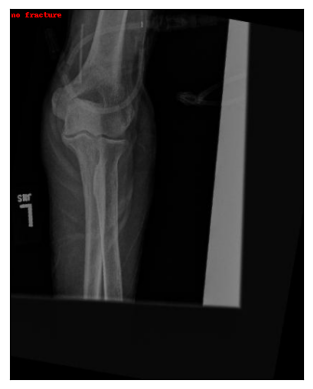

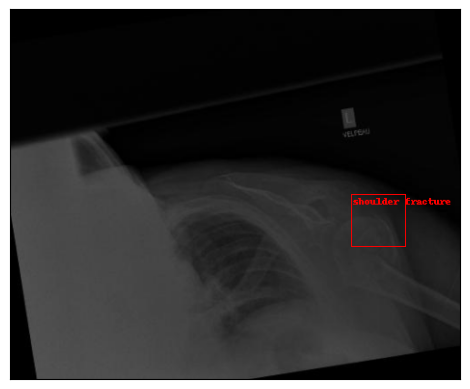

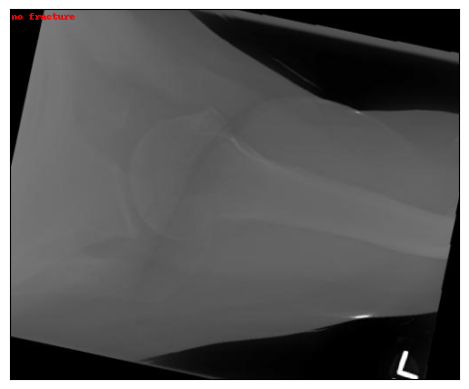

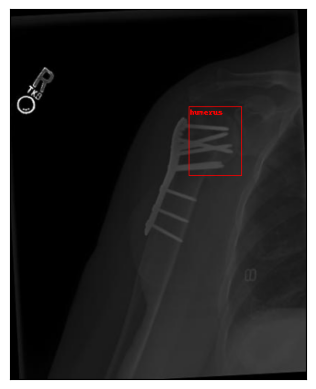

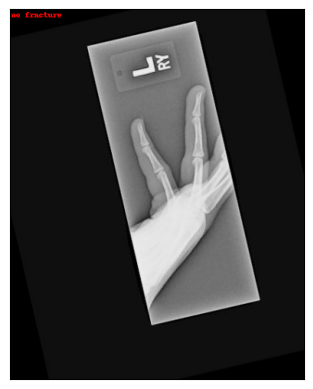

In [10]:
# Double Check access to tensors and labeling data
for index in np.random.randint(len(tnsor_train), size=5):
    img = transforms.functional.convert_image_dtype(tnsor_train.get_image(index), dtype=torch.uint8)
    drawn_boxes = draw_bounding_boxes(img, tnsor_train.get_boxes(index), colors="red", labels=[str(x) for x in tnsor_train.get_labels(index)])
    show(drawn_boxes)

In [11]:
# Create a model to evaluate and their respective train_nodes
m = resnet50()
train_nodes, eval_nodes = get_graph_node_names(resnet50())

assert ([t == e for t, e in zip(train_nodes, eval_nodes)])

# Nodes to select
return_nodes = {
    # node_name: user-specified key for output dict
    'layer1': 'layer1',
    'layer2': 'layer2',
    'layer3': 'layer3',
    'layer4': 'layer4',
}

# Create a feature extractor
feat_ext = create_feature_extractor(m, return_nodes=return_nodes)

c:\Users\micha\anaconda3\lib\site-packages\torch\overrides.py:110: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  torch.has_cuda,
c:\Users\micha\anaconda3\lib\site-packages\torch\overrides.py:112: UserWarning: 'has_cudnn' is deprecated, please use 'torch.backends.cudnn.is_available()'
  torch.has_cudnn,
c:\Users\micha\anaconda3\lib\site-packages\torch\overrides.py:119: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  torch.has_mps,
c:\Users\micha\anaconda3\lib\site-packages\torch\overrides.py:121: UserWarning: 'has_mkldnn' is deprecated, please use 'torch.backends.mkldnn.is_available()'
  torch.has_mkldnn,


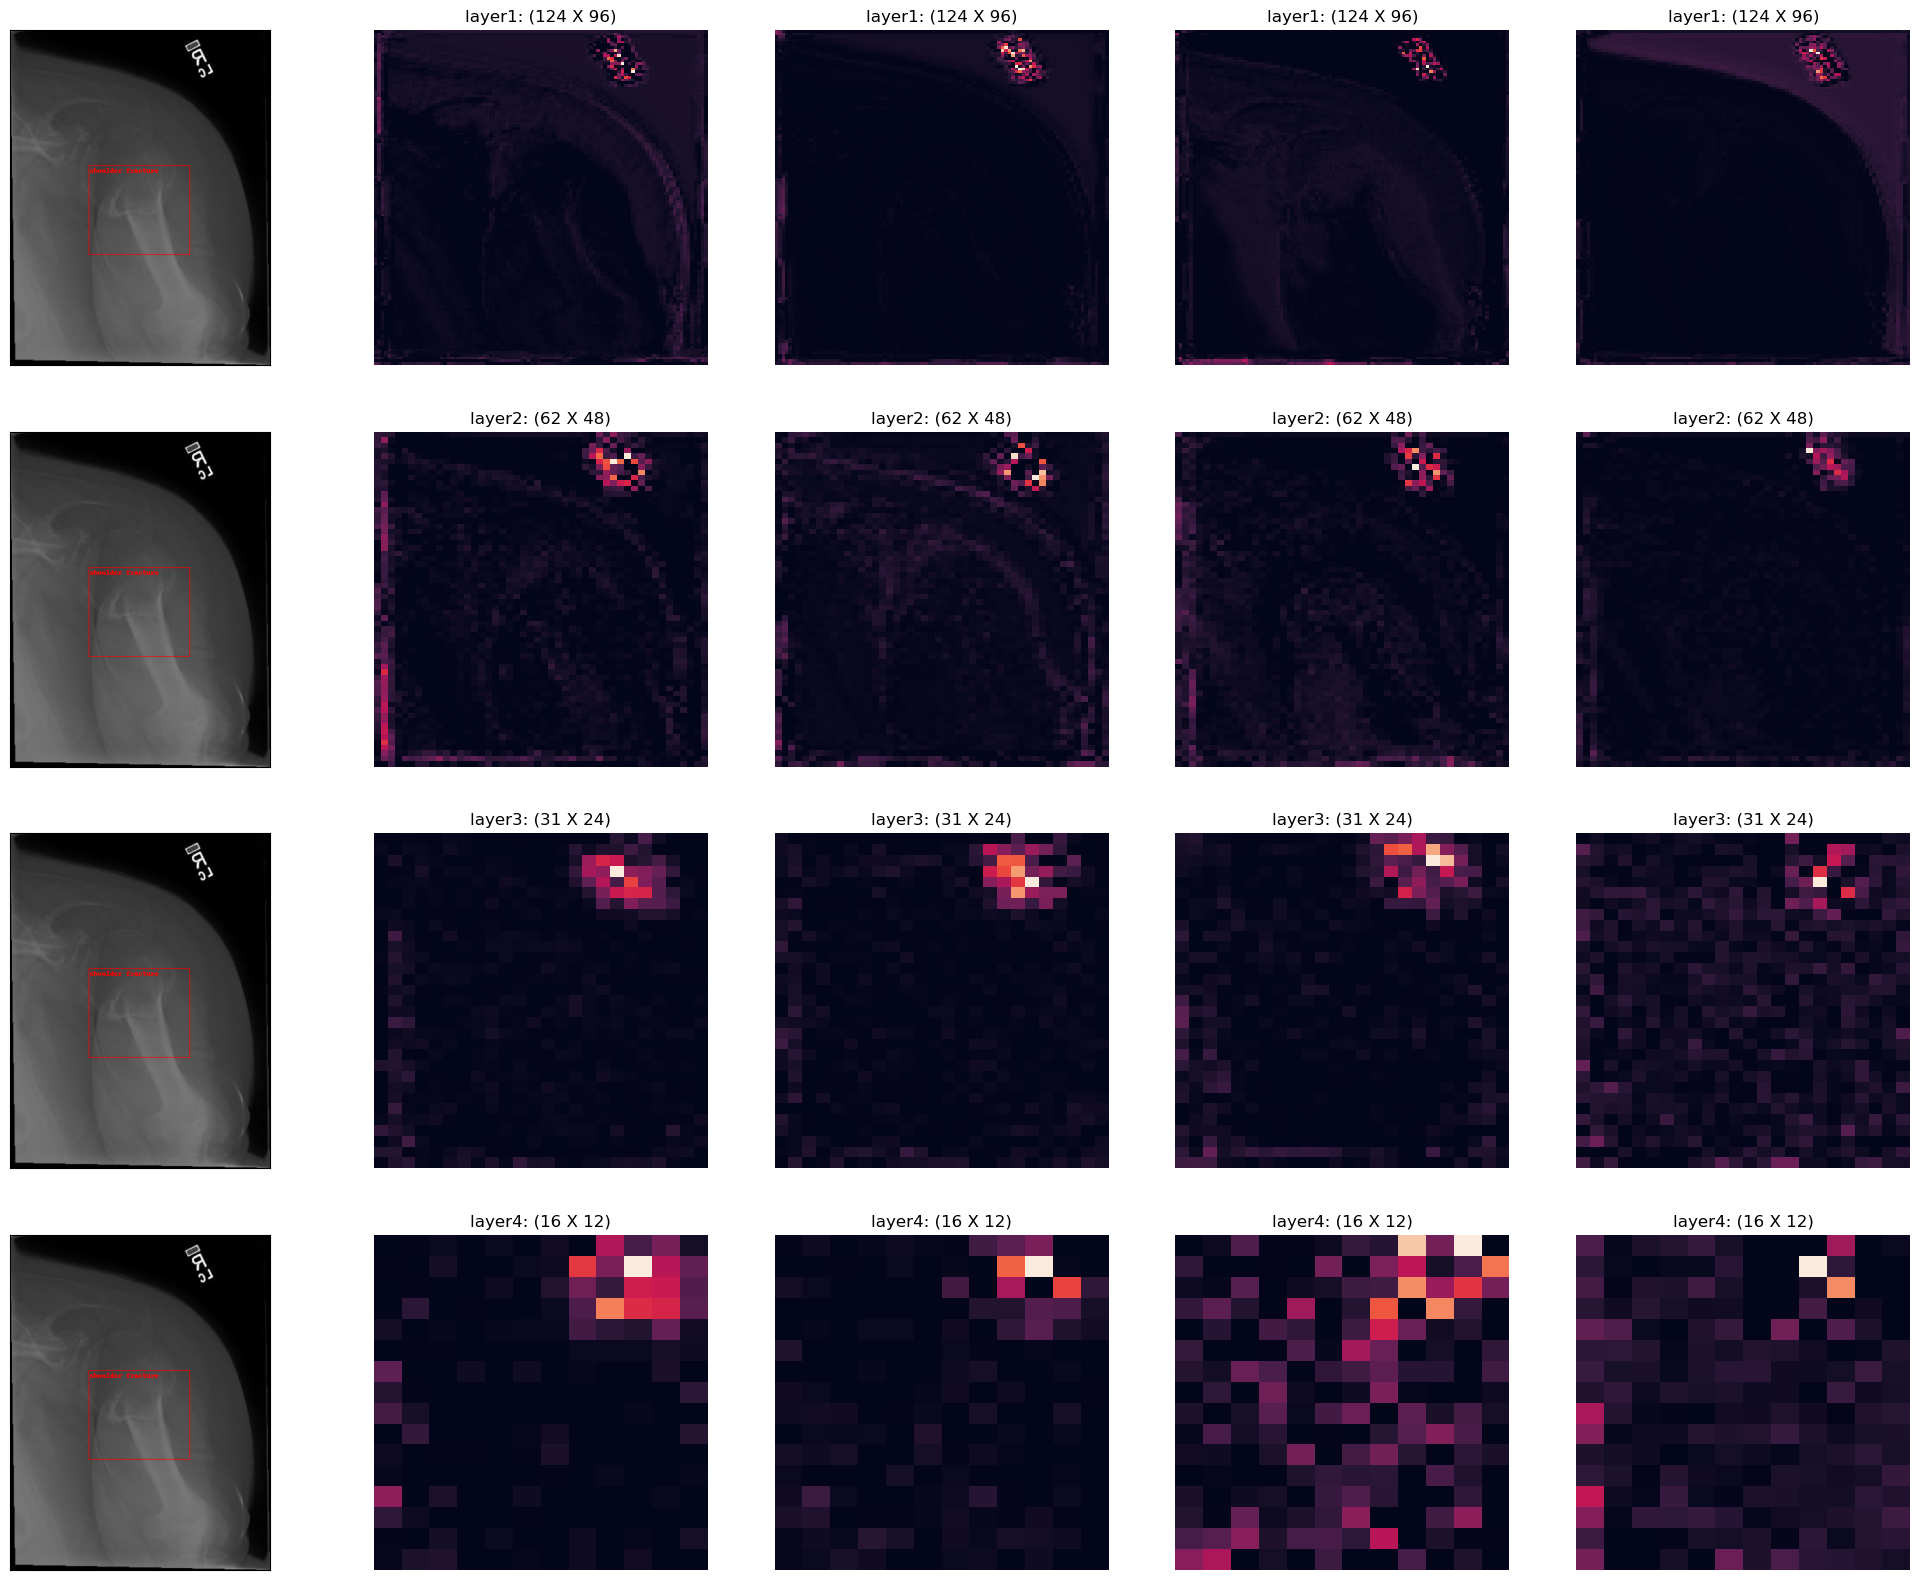

In [13]:
# Test feature extractor
rands = rands = np.random.randint(len(tnsor_train), size=1)
img = transforms.functional.convert_image_dtype(tnsor_train.get_image(rands[0]), dtype=torch.uint8)
with torch.no_grad():
    out = feat_ext(img.unsqueeze(0).float())
display_features(img=img,
                 return_nodes=return_nodes,
                 out=out,
                 tensor=tnsor_train,
                 tensor_index=rands[0])